# Using the Progress Listeners with CPLEX Optimizer

This tutorial includes everything you need to set up Decision Optimization engines, build a mathematical programming model, then use the progress listeners to monitor progress, capture intermediate solutions and stop the solve on your own criteria.

**Table of contents:**

*  [How Decision Optimization can help](#How-Decision-Optimization-can-help)
*  [Use Decision Optimization](#Use-Decision-Optimization)
    *  [Step 1: Set up the prescriptive model](#Step-1:-Set-up-the-prescriptive-model)
    *  [Step 2: Monitoring CPLEX progress](#Step-2:-Monitoring-CPLEX-progress)
    *  [Step 3: Aborting the search with a custom progress listener](#Step-3:-Aborting-the-search-with-a-custom-progress-listener)
    *  [Step 4: Produce advancement charts](#Step-4:-Produce-advancement-charts)
    *  [Variant: using matplotlib to plot a chart of gap vs. time](#Variant:-using-matplotlib-to-plot-a-chart-of-gap-vs.-time)
*  [Summary](#Summary)
****


## How Decision Optimization can help

* Prescriptive analytics (Decision Optimization) technology recommends actions that are based on desired outcomes.  It takes into account specific scenarios, resources, and knowledge of past and current events. With this insight, your organization can make better decisions and have greater control of business outcomes.  

* Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

* Prescriptive analytics takes that insight to the next level by suggesting the optimal way to handle that future situation. Organizations that can act fast in dynamic conditions and make superior decisions in uncertain environments gain a strong competitive advantage.  
<br/>

<u>With prescriptive analytics, you can:</u> 

* Automate the complex decisions and trade-offs to better manage your limited resources.
* Take advantage of a future opportunity or mitigate a future risk.
* Proactively update recommendations based on changing events.
* Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.



## Use Decision Optimization

### Step 1: Set up the prescriptive model

A simple geometric problem is used here to show you how you can leverage progress listeners in the DOcplex Mathematical Programming (MP) API. It is a Mixed Integer Programming (MIP) model.

Progress listeners are designed to monitor the progress of complex MIP search in DOcplex MP, 
that is, linear programs with integer variables.

This model is easily scalable, and thus is appropriate to demonstrate  the progress listener API, but any other scalable MIP model would do.

In [1]:
from docplex.mp.model import Model

def build_hearts(r, **kwargs):
    # initialize the model
    mdl = Model('love_hearts_%d' % r, **kwargs)

    # the dictionary of decision variables, one variable
    # for each circle with i in (1 .. r) as the row and
    # j in (1 .. i) as the position within the row    
    idx = [(i, j) for i in range(1, r + 1) for j in range(1, i + 1)]
    a = mdl.binary_var_dict(idx, name=lambda ij: "a_%d_%d" % ij)

    # the constraints - enumerate all equilateral triangles
    # and prevent any such triangles being formed by keeping
    # the number of included circles at its vertexes below 3

    # for each row except the last
    for i in range(1, r):
        # for each position in this row
        for j in range(1, i + 1):
            # for each triangle of side length (k) with its upper vertex at
            # (i, j) and its sides parallel to those of the overall shape
            for k in range(1, r - i + 1):
                # the sets of 3 points at the same distances clockwise along the
                # sides of these triangles form k equilateral triangles
                for m in range(k):
                    u, v, w = (i + m, j), (i + k, j + m), (i + k - m, j + k - m)
                    mdl.add(a[u] + a[v] + a[w] <= 2)

    mdl.maximize(mdl.sum(a))
    return mdl

First build a small instance of the 'hearts' program and print its characteristics.

In [2]:
m5 = build_hearts(5)
m5.print_information()

Model: love_hearts_5
 - number of variables: 15
   - binary=15, integer=0, continuous=0
 - number of constraints: 35
   - linear=35
 - parameters: defaults
 - objective: maximize
 - problem type is: MILP


### Step 2: Monitoring CPLEX progress

MIP search can take some time for large (or complex) problems. Setting the `log_output=True` in a solve() lets
you display the CPLEX log, which provides lots of information. In certain cases, you might want to take control of what happens at intermediate points in the search, and this is what listeners are designed for.

#### An introduction to progress listeners

Progress listeners are objects, sub-classes of the `docplex.mp.progress.ProgressListener` class. Once a listener has been attached to a model instance (using `Model.add_progress_listener`), it receives method calls from within the CPLEX MIP search. The CPLEX code decides when listeners are called, and this baseline logic cannot be changed. 
However, progress listeners let you select certain types of events.

First, you import the `docplex.mp.progress` module, which contains everything you need about progress listeners.

In [3]:
from docplex.mp.progress import *

#### Monitoring MIP search progress

The simplest class of listener is the `TextProgressListener`, which prints a message on the STDOUT each time it is called. See what this does on the small model.

In [4]:
# connect a listener to the model
m5.add_progress_listener(TextProgressListener())

#### Solve with Decision Optimization

You must use an environment that has the full version of CPLEX (<i>DO + NLP Runtime xx.x on Python 3.x</i>). Otherwise, depending on the size of the problem, the solve stage might fail.

Here, you solve with the ***clean_before_true*** flag set to True, as you want each solve to produce the same output. Without this flag, a second solve on the model would start from the first solve solution, and would not have the same output.

In [5]:
m5.solve(clean_before_solve=True);

  1+: Node=0 Left=1 Best Integer=5.0000, Best Bound=10.0000, gap=100.00%, ItCnt=21 [0.0s]
  2+: Node=0 Left=1 Best Integer=6.0000, Best Bound=10.0000, gap=66.67%, ItCnt=21 [0.0s]
  3+: Node=0 Left=1 Best Integer=6.0000, Best Bound=9.3266, gap=55.44%, ItCnt=33 [0.0s]
  4+: Node=0 Left=1 Best Integer=7.0000, Best Bound=9.3266, gap=33.24%, ItCnt=33 [0.0s]
  5+: Node=0 Left=1 Best Integer=7.0000, Best Bound=9.1900, gap=31.29%, ItCnt=40 [0.0s]
  6+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.1900, gap=14.88%, ItCnt=40 [0.0s]
  7+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.0233, gap=12.79%, ItCnt=53 [0.0s]


The listener prints one line each time it is called by CPLEX code; from this you can see that:

   - the listener is called several times from the same node 
   - the listener is called several times at the same iteration 
   - the listener is called several times with the same objective 
   
In each line, the '+' indicates that an intermediate solution is available at the time of the call. In this case, an intermediate solution was available at each call, but this is not always the case.
Looking closer, you can also see that the listener reacts to events which improve either the objective or the best bound.
This is due to the value of the _clock_ attribute of the listener.

#### Listener clocks

Clocks are values of the enumerated type `docplex.mp.progress.ProgressClock`, which defines types of events to listen to. Every listener has a clock, the default being `ProgressClock.Gap`, which reacts when an event satisfies the following conditions:

   - an intermediate solution is available 
   - either the objective has improved _or_ the best bound has improved
    
You can see this with this model:

In [6]:
for l, listener in enumerate(m5.iter_progress_listeners(), start=1):
    print("listener #{0} has type '{1}', clock={2}".format(l, listener.__class__.__name__, listener.clock))

listener #1 has type 'TextProgressListener', clock=ProgressClock.Gap


Now, you can experiment with a text progress listener listening to the `All` clock, that is the baseline clock that reacts to all calls from CPLEX. To do so, first clear all progress listeners and add a new one.

Note that the constructor also accepts strings, interpreted as the clock name.

In [7]:
m5.clear_progress_listeners()
m5.add_progress_listener(TextProgressListener(clock='all'))
m5.solve(clean_before_solve=True);

  1+: Node=0 Left=1 Best Integer=5.0000, Best Bound=10.0000, gap=100.00%, ItCnt=21 [0.0s]
  2+: Node=0 Left=1 Best Integer=5.0000, Best Bound=10.0000, gap=100.00%, ItCnt=21 [0.0s]
  3+: Node=0 Left=1 Best Integer=6.0000, Best Bound=10.0000, gap=66.67%, ItCnt=21 [0.0s]
  4+: Node=0 Left=1 Best Integer=6.0000, Best Bound=10.0000, gap=66.67%, ItCnt=33 [0.0s]
  5+: Node=0 Left=1 Best Integer=6.0000, Best Bound=9.3266, gap=55.44%, ItCnt=33 [0.0s]
  6+: Node=0 Left=1 Best Integer=7.0000, Best Bound=9.3266, gap=33.24%, ItCnt=33 [0.0s]
  7+: Node=0 Left=1 Best Integer=7.0000, Best Bound=9.3266, gap=33.24%, ItCnt=40 [0.0s]
  8+: Node=0 Left=1 Best Integer=7.0000, Best Bound=9.1900, gap=31.29%, ItCnt=40 [0.0s]
  9+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.1900, gap=14.88%, ItCnt=40 [0.0s]
 10+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.1900, gap=14.88%, ItCnt=47 [0.0s]
 11+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.1067, gap=13.83%, ItCnt=47 [0.0s]
 12+: Node=0 Left=1 Best I

In this case, the listener is called more often, sometimes with identical objective and bound (see lines 3 and 4). This explains why the default clock is __Gap__, to focus on actual changes.

Other possible values for the clock enumerated type are:

   - __Solutions__: listens to all intermediate solutions, whether or not they improve the objective or best bound.
   - __Objective__: listens to intermediate solutions, which improve the objective.
   
How exactly is improvement measured? A listener constructor can specify an _absdiff_ and _reldiff_ parameters which are interpreted as the minimal absolute (resp. relative) improvement to accept (or not) a call from CPLEX.

You can see this here with a third `TextProgressListener` with clock set to 'objective' and an absolute diff of 1. You can expect this listener to react whenever the objective has improved by an amount greater than 1:

In [8]:
m5.clear_progress_listeners()
m5.add_progress_listener(TextProgressListener(clock='objective', absdiff=1, reldiff=0))
m5.solve(clean_before_solve=True);

  1+: Node=0 Left=1 Best Integer=5.0000, Best Bound=10.0000, gap=100.00%, ItCnt=21 [0.0s]
  2+: Node=0 Left=1 Best Integer=6.0000, Best Bound=10.0000, gap=66.67%, ItCnt=21 [0.0s]
  3+: Node=0 Left=1 Best Integer=7.0000, Best Bound=9.3266, gap=33.24%, ItCnt=33 [0.0s]
  4+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.1900, gap=14.88%, ItCnt=40 [0.0s]


As expected, the listener accepted four events, with increasing objective values of 5, 6, 7 and 8.

#### Monitor progress: manage intermediate solutions

This is done by another predefined listener class: `SolutionRecorder`. This type of listener is a subclass of the `SolutionListerer` class. Again, this listener contains a _clock_ parameter (default is __Gap__) which controls which events are accepted or not.

The default behavior is to accept only solutions, which improve either the objective or the best bound.

In [9]:
from docplex.mp.progress import SolutionRecorder

sol_recorder = SolutionRecorder()
m5.clear_progress_listeners()
m5.add_progress_listener(sol_recorder)

Again, solve with the `clean_before_solve` flag set to `True` to ensure a deterministic behavior.

In [10]:
m5.solve(clean_before_solve=True);

At the end of the solve, the recorder contains all the intermediate solutions.
Now, you can display some information about these intermediate solutions.

In [11]:
# utility function to display recorded solutions in a recorder.
def display_recorded_solutions(rec):
    print('* The recorder contains {} solutions'.format(rec.number_of_solutions))
    for s, sol in enumerate(rec.iter_solutions(), start=1):
        sumvals = sum(v for _, v in sol.iter_var_values())
        print('  - solution #{0}, obj={1}, non-zero-values={2}, total={3}'.format(
           s, sol.objective_value, sol.number_of_var_values, sumvals))
        
display_recorded_solutions(sol_recorder)

* The recorder contains 7 solutions
  - solution #1, obj=5.0, non-zero-values=15, total=5.0
  - solution #2, obj=6.0, non-zero-values=15, total=6.0
  - solution #3, obj=6.0, non-zero-values=15, total=6.0
  - solution #4, obj=7.0, non-zero-values=15, total=7.0
  - solution #5, obj=7.0, non-zero-values=15, total=7.0
  - solution #6, obj=8.0, non-zero-values=15, total=8.0
  - solution #7, obj=8.0, non-zero-values=15, total=8.0


Now, you can try a solution recorder with a different clock: __Objective__. This recorder will record only intermediate solutions which improve the objective, regardless of the best bound. Such changes occur less frequently than the Gap clock, so you can expect less solutions to be recorded.

In [12]:
sol_recorder2 = SolutionRecorder(clock='objective')
m5.clear_progress_listeners()
m5.add_progress_listener(sol_recorder2)
m5.solve(clean_before_solve=True)
display_recorded_solutions(sol_recorder2)

* The recorder contains 4 solutions
  - solution #1, obj=5.0, non-zero-values=15, total=5.0
  - solution #2, obj=6.0, non-zero-values=15, total=6.0
  - solution #3, obj=7.0, non-zero-values=15, total=7.0
  - solution #4, obj=8.0, non-zero-values=15, total=8.0


As expected, the 'objective' recorder stored only 4 solutions instead of 7. Only one solution with each objective is recorded, instead of several with the 'Gap' recorder.

### Step 3: Aborting the search with a custom progress listener

MIP search can be time-consuming; in some cases, a 'good-enough' solution can be sufficient.
For example, when the gap is converging very slowly, it might be a good idea to stop and use the last solution instead of waiting for a long time to prove optimality.

Assume that you want to implement the following behavior: 
stop the search when the listener ha sbeen called N times without any improvement in the objective. This
is not quite realistic, as one would rather use a time limit, but this may lead to non-deterministic behaviors.

The first question to ask is: what clock do you listen to? As you want to stop as soon as 
elapsed time without improvement is greater than your limit, you can listen to the higher frequency clock, `All` clock.

Second, as you do not need to report solutions, you can sub-class from `ProgressListener`, not from `SolutionListener`.

What do you need to code this aborter? You need to know whether an incumbent solution is present, and what its objective value is, then check whether the objective has improved or not.
If it has improved, you can store the value of the objective and the time (obtained through `ProgressData.time`).
If not, you can check whether the elapsed time is greater than the limit, and if it is the case, call method `abort()`.

The 'abort()' method must be called inside a 'notify_progress' call, otherwise it will have no effect.

The code is as follows:

In [13]:
from docplex.mp.progress import ProgressListener

class AutomaticAborter(ProgressListener):
    """ a simple implementation of an automatic search stopper.
    """
    def __init__(self, max_no_improve_events=100):
        super(AutomaticAborter, self).__init__(ProgressClock.All)
        self.last_obj = None
        self.nb_events_since_last_obj = 0
        self.max_no_improve_events = max_no_improve_events
        
    def notify_start(self):
        super(AutomaticAborter, self).notify_start()
        self.last_obj = None
        self.nb_events_since_last_obj = 0
        
    def is_improving(self, new_obj, eps=1e-4):
        last_obj = self.last_obj
        return last_obj is None or (abs(new_obj- last_obj) >= eps)
            
    def notify_progress(self, pdata):
        super(AutomaticAborter, self).notify_progress(pdata)
        if pdata.has_incumbent and self.is_improving(pdata.current_objective):
            self.last_obj = pdata.current_objective
            self.nb_events_since_last_obj = 0
            print('----> #new objective={0}'.format(self.last_obj))
        elif self.last_obj is not None:
            # a non improving move
            self.nb_events_since_last_obj += 1
            if self.nb_events_since_last_obj >= self.max_no_improve_events:
                print('!! aborting cplex, non_improving={0} >= max_no_improve: {1}'.format(self.nb_events_since_last_obj,
                                                                             self.max_no_improve_events))
                self.abort()
            else:
                print('----> nb non-improving events={0}/{1}'.format(self.nb_events_since_last_obj, self.max_no_improve_events))

Now see the aborter used on a larger problem:

In [14]:
large_hearts = build_hearts(9)
#large_hearts.add_progress_listener(TextProgressListener(clock='gap'))
# maximum non-improving time is 4 seconds.
large_hearts.add_progress_listener(AutomaticAborter(max_no_improve_events=20))
# again use clean_before_solve to ensure deterministic run of this cell.
large_hearts.solve(clean_before_solve=True, log_output=False);

----> #new objective=13.0
----> nb non-improving events=1/20
----> #new objective=14.0
----> nb non-improving events=1/20
----> nb non-improving events=2/20
----> #new objective=15.0
----> nb non-improving events=1/20
----> nb non-improving events=2/20
----> nb non-improving events=3/20
----> nb non-improving events=4/20
----> #new objective=16.0
----> nb non-improving events=1/20
----> nb non-improving events=2/20
----> nb non-improving events=3/20
----> nb non-improving events=4/20
----> nb non-improving events=5/20
----> nb non-improving events=6/20
----> nb non-improving events=7/20
----> nb non-improving events=8/20
----> nb non-improving events=9/20
----> nb non-improving events=10/20
----> nb non-improving events=11/20
----> nb non-improving events=12/20
----> nb non-improving events=13/20
----> nb non-improving events=14/20
----> nb non-improving events=15/20
----> nb non-improving events=16/20
----> nb non-improving events=17/20
----> nb non-improving events=18/20
----> nb non

The solve has aborted, it returned the latest solution. You can see this in the solve details' status value.

In [15]:
large_s = large_hearts.solution
print('* solution has objective {0}'.format(large_s.objective_value))
print("* solve status is '{}'".format(large_hearts.solve_details.status))

* solution has objective 17.0
* solve status is 'aborted'


### Step 4: Produce advancement charts

Progress listeners can also be used to generate visual charts to plot the advancement of the solve.
For example, assume you want to plot the chart of the gap vs. time.
In a first version, you will just print the value of the gap and time.
What clock do you listen to? Here you can listen to the `Gap` clock, and do not need to report solution values,
so you can use a sub-class of `ProgressListener`.

As this listener has no internal data, there is no need to write a `notify_start` method.

The `notify_progress` consists of printing a formatted message with the gap and time.

The code is as follows:

In [16]:
class MipGapPrinter(ProgressListener):
  
    def __init__(self):
        ProgressListener.__init__(self, ProgressClock.Gap)
    
    def notify_progress(self, pdata):
        gap = pdata.mip_gap
        ms_time = 1000* pdata.time
        print('-- new gap: {0:.1%}, time: {1:.0f} ms'.format(gap, ms_time))

In [17]:
m8 = build_hearts(8)
m8.add_progress_listener(MipGapPrinter())
m8.solve(clean_before_solve=True);

-- new gap: 100.0%, time: 5 ms
-- new gap: 93.5%, time: 10 ms
-- new gap: 89.0%, time: 18 ms
-- new gap: 74.5%, time: 19 ms
-- new gap: 72.9%, time: 25 ms
-- new gap: 71.8%, time: 34 ms
-- new gap: 70.8%, time: 43 ms
-- new gap: 69.9%, time: 49 ms
-- new gap: 68.9%, time: 56 ms
-- new gap: 67.8%, time: 67 ms
-- new gap: 55.9%, time: 69 ms
-- new gap: 55.1%, time: 98 ms
-- new gap: 30.0%, time: 147 ms
-- new gap: 24.3%, time: 170 ms
-- new gap: 21.4%, time: 178 ms
-- new gap: 19.0%, time: 182 ms
-- new gap: 16.7%, time: 189 ms
-- new gap: 14.3%, time: 193 ms
-- new gap: 12.5%, time: 202 ms
-- new gap: 10.7%, time: 205 ms
-- new gap: 9.5%, time: 206 ms
-- new gap: 8.3%, time: 210 ms
-- new gap: 0.0%, time: 214 ms


### Variant: using matplotlib to plot a chart of gap vs. time

In this variant, use `matplotlib` to chart the evolution of gap over time. The logic of the custom listener is exactly the same as with the gap printer, except that you call matplotlib.plot instead of printing a message.

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline


In [19]:
from docplex.mp.progress import ProgressListener, ProgressClock
from IPython import display

class MipGapPlotter(ProgressListener):
    
    def __init__(self):
        ProgressListener.__init__(self, ProgressClock.Gap)
        plt.ion()
        self.fig = plt.figure(figsize=(10,4))
        self.ax = self.fig.add_subplot(1,1,1)
    
    def notify_start(self):
        self.times =[]
        self.gaps = []
        #self.lines, = ax.plot([],[], 'o')
        plt.xlabel('time (ms)')
        plt.ylabel('gap (%)')
        
    def notify_progress(self, pdata):
        gap = pdata.mip_gap
        time = pdata.time
        self.times.append(1000* time)
        self.gaps.append(100*gap)
        plt.plot(self.times, self.gaps, 'go-')
        display.display(plt.gcf())
        display.clear_output(wait=True)


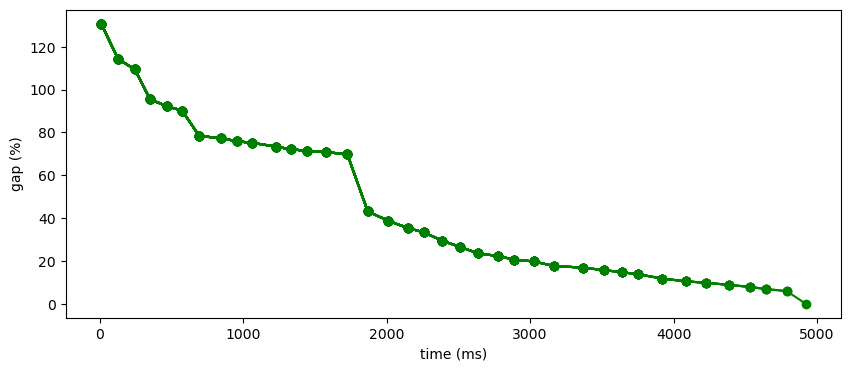

In [20]:
m9 = build_hearts(9)
m9.add_progress_listener(MipGapPlotter())
m9.solve(clean_before_solve=True);

## Summary


You learned how to set up and use the IBM Decision Optimization CPLEX Modeling for Python to formulate a Mathematical Programming model and track its progress.

#### References
* <a href="https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html" target="_blank" rel="noopener noreferrer">Decision Optimization CPLEX Modeling for Python documentation</a>
* <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html?context=cpdaas" target="_blank" rel="noopener noreferrer">IBM Cloud Pak for Data as a Service documentation</a>
* <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html?context=wx" target="_blank" rel="noopener noreferrer">IBM watsonx.ai documentation</a>



<hr>
Copyright &copy; 2017-2025 IBM. This notebook and its source code are released under the terms of the MIT License.